In [1]:
import numpy as np
import pandas as pd
from model.models import *
import matplotlib.pyplot as plt
from sklearn import metrics
import torch
import shap
from sklearn.metrics import roc_auc_score
from balanceSHAP import process, SHAP

seed = 1234
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)
%load_ext autoreload
%autoreload 2

def get_ci_auc(y_true, y_pred, alpha=0.05):
    n_bootstraps = 1000
    bootstrapped_scores = []

    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred) - 1, len(y_pred))

        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # c.i.
    confidence_lower = sorted_scores[int(alpha/2 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(1-alpha/2 * len(sorted_scores))]

    return round(confidence_lower, 3), round(confidence_upper, 3)

In [2]:
data = pd.read_csv("./data/data.csv")
feature_names = data.drop(columns="label").columns
num_vars = len(feature_names)
event_rate = round(np.mean(data["label"] == 1), 3)
mor = round(event_rate, 3)

bg_mor = 0.5 # [mor, 0.2, 0.3, 0.4, 0.5]
bg_size = 1000
train_data, val_data, test_data = process.stratify_split(data, [6, 2, 2])

## Regular data processing

In [3]:
x_train = train_data.drop(columns="label").values
x_val = val_data.drop(columns="label").values
x_test = test_data.drop(columns="label").values

## 0-1 normalization
train_min, train_max = x_train.min(axis=0), x_train.max(axis=0)
x_train = (x_train - train_min) / (train_max - train_min)
x_val = (x_val - train_min) / (train_max - train_min)
x_test = (x_test - train_min) / (train_max - train_min)

y_train = train_data["label"].values
y_val = val_data["label"].values
y_test = test_data["label"].values

x_train_tensor = torch.FloatTensor(x_train)
x_val_tensor = torch.FloatTensor(x_val)
x_test_tensor = torch.FloatTensor(x_test)

y_train_tensor = torch.LongTensor(y_train)
y_validation_tensor = torch.LongTensor(y_val)
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=31442, shuffle=True)

## Targeted model

In [4]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

model_use = "MLP"
if model_use == "MLP":
    model = MLP(num_vars)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  # 1e-2 for 0.088
weights = [0.088, 0.912]
class_weights = torch.FloatTensor(weights)
criterion = nn.CrossEntropyLoss(weight=class_weights)
auc_value = np.zeros(40)
prc_value = np.zeros(40)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(
                epoch, loss.item()))


for i in range(1, 201):
    train(i)
    i_tmp = i % 5
    if i_tmp == 0:
        model.eval()
        # calculate the fpr and tpr for all thresholds of the classification
        y_pred_tmp = model(x_val_tensor)
        loss_val = criterion(y_pred_tmp, y_validation_tensor)
        print('Loss on validation set:{:.6f}'.format(loss_val.item()))

        preds_tmp = y_pred_tmp[:, 1]
        preds1_tmp = preds_tmp.detach().numpy()
        fpr, tpr, threshold = metrics.roc_curve(
            y_val, preds1_tmp)
        prc = metrics.precision_score(y_val, y_pred_tmp.argmax(1))
        roc_auc = metrics.auc(fpr, tpr)
        auc_value[(i // 5)-1] = roc_auc
        # store the model
        PATH = "./model/{} ({}) with {} epochs training (01 normalization).pt".format(
            model_use, mor, i // 5)
        torch.save(model, PATH)

print(max(auc_value))
print(str(np.argmax(auc_value) + 1))

epoch = np.argmax(auc_value) + 1
model = torch.load(
    "./model/{} ({}) with {} epochs training (01 normalization).pt".format(model_use, mor, epoch))
# print(model)
model.eval()
y_pred_tmp = model(x_test_tensor)
y_pred_output = y_pred_tmp[:, 1].detach().numpy()
fpr, tpr, threshold = metrics.roc_curve(
    y_test, y_pred_output)
roc_auc = metrics.auc(fpr, tpr)
auc_ci = get_ci_auc(y_test, y_pred_output, alpha=0.05)
print(f"------------AUC on test: {metrics.auc(fpr, tpr)} (CI: {auc_ci})-----------")
print(roc_auc)

Train Epoch: 1 	Loss: 0.697494
Train Epoch: 2 	Loss: 0.695041
Train Epoch: 3 	Loss: 0.692336
Train Epoch: 4 	Loss: 0.690310
Train Epoch: 5 	Loss: 0.686811
Loss on validation set:0.680501
Train Epoch: 6 	Loss: 0.681701
Train Epoch: 7 	Loss: 0.676433
Train Epoch: 8 	Loss: 0.667930
Train Epoch: 9 	Loss: 0.661510
Train Epoch: 10 	Loss: 0.653710
Loss on validation set:0.639441
Train Epoch: 11 	Loss: 0.644498
Train Epoch: 12 	Loss: 0.643788
Train Epoch: 13 	Loss: 0.634547
Train Epoch: 14 	Loss: 0.631377
Train Epoch: 15 	Loss: 0.629639
Loss on validation set:0.619587
Train Epoch: 16 	Loss: 0.624640
Train Epoch: 17 	Loss: 0.621744
Train Epoch: 18 	Loss: 0.617594
Train Epoch: 19 	Loss: 0.614564
Train Epoch: 20 	Loss: 0.613544
Loss on validation set:0.608292
Train Epoch: 21 	Loss: 0.610919
Train Epoch: 22 	Loss: 0.605949
Train Epoch: 23 	Loss: 0.606080
Train Epoch: 24 	Loss: 0.596045
Train Epoch: 25 	Loss: 0.596453
Loss on validation set:0.592727
Train Epoch: 26 	Loss: 0.595525
Train Epoch: 27 	

## balanceSHAP: Generating background and explanation data

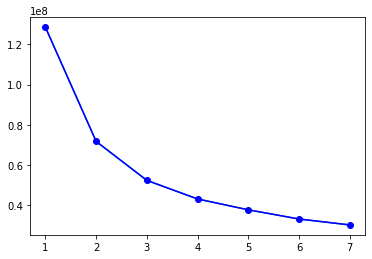

(array([0, 1, 2]), array([3314, 4304,  574], dtype=int64))



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
bg_mor = 0.5 # [mor, 0.2, 0.3, 0.4, 0.5]
bg_size = 1000
background_data = process.generate_background(train_data, bg_size, bg_mor)
unbalanced_background_data = process.generate_background(train_data, bg_size, event_rate) # stratify sampling

kmax = 7
sse = process.calculate_WSS(val_data.loc[val_data["label"] == 0, ].drop(columns="label"), kmax)
explanation_data = process.undersample_kmeans(val_data, 0.5, n_clusters = 3)
unbalanced_explanation_data = val_data

In [6]:
x_background = background_data.drop(columns="label").values
x_explanation = explanation_data.drop(columns="label").values
x_unbalanced_background = unbalanced_background_data.drop(columns="label").values
x_unbalanced_explanation = unbalanced_explanation_data.drop(columns="label").values

x_background = (x_background - train_min) / (train_max - train_min)
x_explanation = (x_explanation - train_min) / (train_max - train_min)
x_unbalanced_background = (x_unbalanced_background - train_min) / (train_max - train_min)
x_unbalanced_explanation = (x_unbalanced_explanation - train_min) / (train_max - train_min)

x_background_tensor = torch.FloatTensor(x_background)
x_explanation_tensor = torch.FloatTensor(x_explanation)
x_unbalanced_background_tensor = torch.FloatTensor(x_unbalanced_background)
x_unbalanced_explanation_tensor = torch.FloatTensor(x_unbalanced_explanation)

## balanceSHAP: shap computation

In [7]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

balanced_shaps = SHAP.shap_values(model, x_background_tensor, x_explanation_tensor)
unbalanced_shaps = SHAP.shap_values(model, x_unbalanced_background_tensor, x_unbalanced_explanation_tensor)


SHAP computation:: 100%|██████████| 8981/8981 [23:42<00:00,  6.31it/s]


## SHAP: Beeswarm plot 

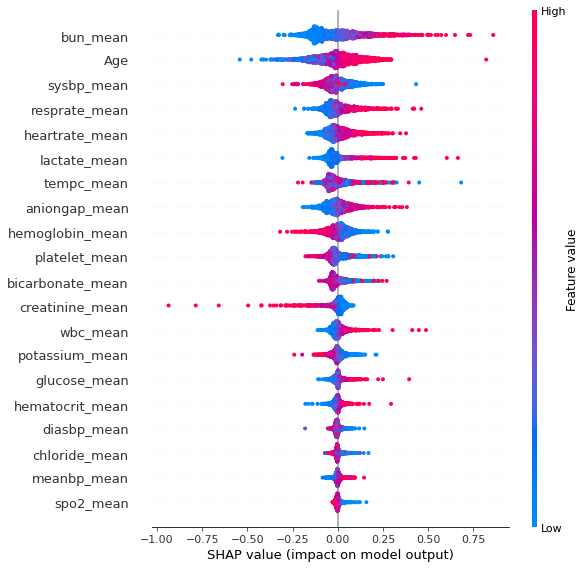

In [8]:
shap.initjs()
fig = plt.figure()
shap.summary_plot(balanced_shaps, features=x_explanation, feature_names=feature_names, plot_size='auto')

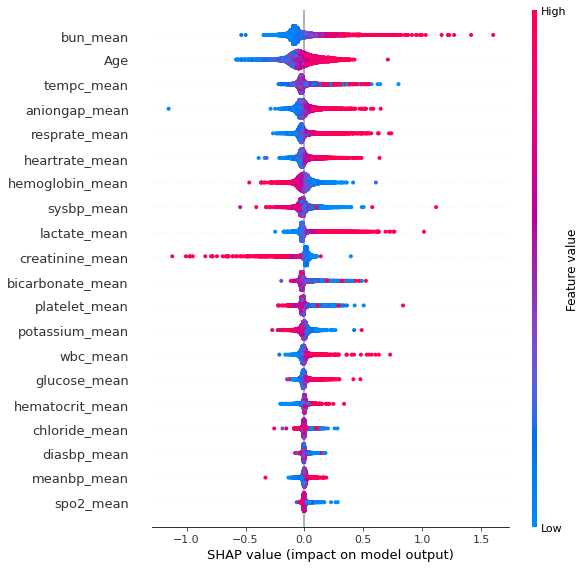

In [9]:
shap.initjs()
fig = plt.figure()
shap.summary_plot(unbalanced_shaps, features=x_unbalanced_explanation, feature_names=feature_names, plot_size='auto')